In [1]:
import numpy as np
import cv2
from skimage.feature import hog
import matplotlib.pyplot as plt
import glob
import time
import os
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
sns.set_style("white")
sns.set_context('poster')

DATA_DIR = '../data/'


In [2]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def rgb2any(image, color_space):
    # apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else:
        image = np.copy(image)      
    return image

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        feature_image = rgb2any(image, color_space)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    return features


# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img)
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    feature_image = rgb2any(img, color_space)
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    on_windows = []    # Create an empty list to receive positive detection windows
    for window in windows:
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        # Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        # Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        prediction = clf.predict(test_features)
        # If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    return on_windows    


In [3]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list



In [4]:
def add_heat(heatmap, bbox_list):                #Supplementary function for making bounding boxes
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap

def apply_threshold(heatmap, threshold):    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    return heatmap

def draw_labeled_bboxes(img, labels):
    bboxes = []
    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        bboxes.append(bbox)
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    return img, bboxes

def sum_deque(d):
    cumulated = np.zeros((720,1280))
    for heated_image in d:
        cumulated += heated_image
    return cumulated

In [5]:
#Pipeline for process an image
#Tracking last 5 frames
from collections import deque
d= deque(maxlen=5)


def process_image(img):
    image = img.astype(np.float32) / 255.
    big_windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 700], 
                    xy_window=(165, 144), xy_overlap=(0.8, 0.7))
    middle_windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 700], 
                    xy_window=(143, 116), xy_overlap=(0.8,0.6))
    small_windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 550], 
                    xy_window=(96, 72), xy_overlap=(0.7,0.7))
    smaller_windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 450], 
                    xy_window=(77, 62), xy_overlap=(0.9,0.8))
    windows = small_windows + middle_windows + big_windows + smaller_windows

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       
         
    window_img = draw_boxes(image, hot_windows, color=(0, 0, 255), thick=6) 

    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heatmap = add_heat(heat, hot_windows)
    d.append(heatmap)
    cumulated_heatmap = sum_deque(d)
    
    heatmap = apply_threshold(cumulated_heatmap, 10)
    labels = label(heatmap)
    draw_img, bboxes = draw_labeled_bboxes(img, labels)
    return draw_img


In [6]:
#Training SVC
# Read in cars and notcars
notcars = glob.glob(DATA_DIR + 'non-vehicles/*/*.png')
cars = glob.glob(DATA_DIR + 'vehicles/*/*.png')


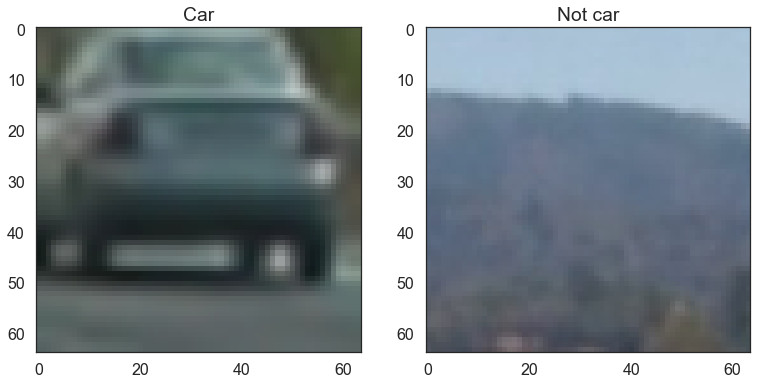

In [7]:
i = 25
plt.subplot(121)
plt.imshow(plt.imread(cars[i]))
plt.title('Car')
plt.subplot(122)
plt.imshow(plt.imread(notcars[i]))
plt.title('Not car')
plt.savefig('./output_images/car_notcar.png')


In [8]:

#Choosing paramators for SVC
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [360, 720] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)


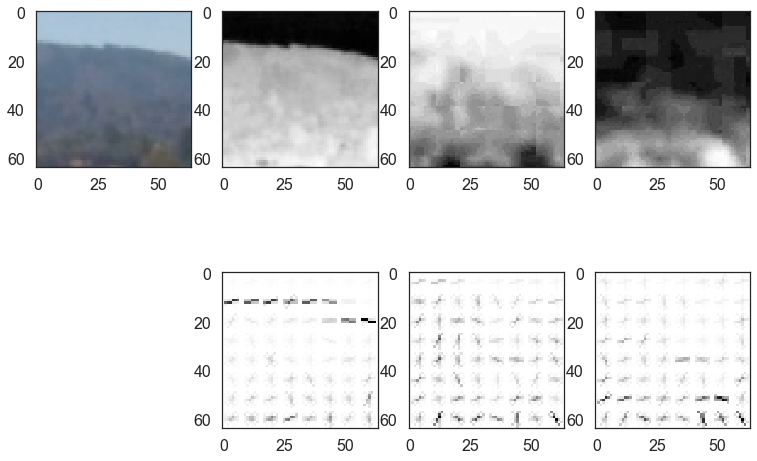

In [9]:
# _, hog_image_car = get_hog_features(plt.imread(cars[i]), orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
# plt.imread(cars[i]).shape
sns.set_context('poster')

def draw_hog_feature(image):
    feature_image = rgb2any(image, color_space)
    plt.figure()
    plt.subplot(2, feature_image.shape[2] + 1, 1)
    plt.imshow(image)
    plt.subplot(2, feature_image.shape[2] + 1, 2)
    plt.imshow(feature_image[:, :, 0])
    plt.subplot(2, feature_image.shape[2] + 1, 3)
    plt.imshow(feature_image[:, :, 1])
    plt.subplot(2, feature_image.shape[2] + 1, 4)
    plt.imshow(feature_image[:, :, 2])

    # plt.subplot(1, feature_image.shape[2] + 2, 2)
    # plt.imshow(feature_image)
    for channel in range(feature_image.shape[2]):
        _, hog_image_car = get_hog_features(feature_image[:,:,channel], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
        plt.subplot(2, feature_image.shape[2] + 1, channel + 6)
        plt.imshow(hog_image_car)
    
draw_hog_feature(mpimg.imread(cars[i]))
plt.savefig('./output_images/car_feature.png')
plt.close()

draw_hog_feature(mpimg.imread(notcars[i]))
plt.savefig('./output_images/notcar_feature.png')



In [10]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
X_scaler = StandardScaler().fit(X)      # Fit scaler
scaled_X = X_scaler.transform(X)      # Apply the scaler to X
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))    # labels

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
svc = LinearSVC()             # Use a linear SVC 
# Check the training time for the SVC
svc.fit(X_train, y_train)
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

('Using:', 9, 'orientations', 8, 'pixels per cell and', 2, 'cells per block')
('Feature vector length:', 6108)
('Test Accuracy of SVC = ', 0.9859)


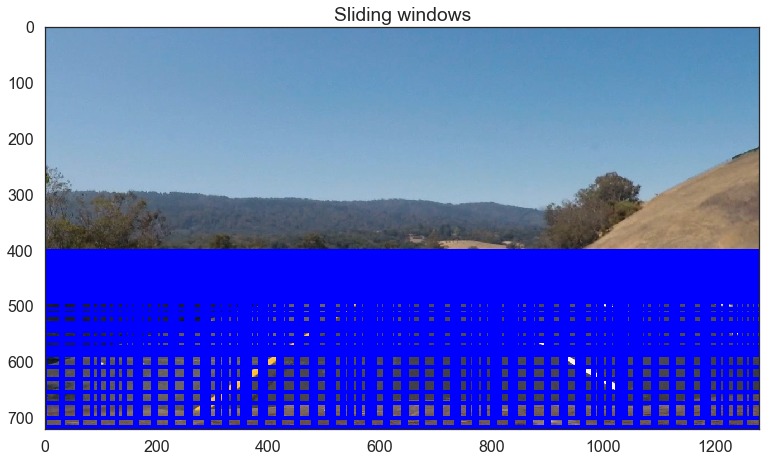

In [11]:
image = mpimg.imread('test_images/test3.jpg')
image = image.astype(np.float32)/255
draw_image = np.copy(image)
big_windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 700], 
                    xy_window=(165, 144), xy_overlap=(0.8, 0.7))
middle_windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 700], 
                xy_window=(143, 116), xy_overlap=(0.8,0.6))
small_windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 550], 
                xy_window=(96, 72), xy_overlap=(0.7,0.7))
smaller_windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 450], 
                xy_window=(77, 62), xy_overlap=(0.9,0.8))
windows = small_windows + middle_windows + big_windows + smaller_windows

#Visualising sliding windows
plt.imshow(draw_boxes(draw_image, windows, color=(0, 0, 1), thick=6) )
plt.title('Sliding windows')
plt.savefig('output_images/sliding_windows.png')

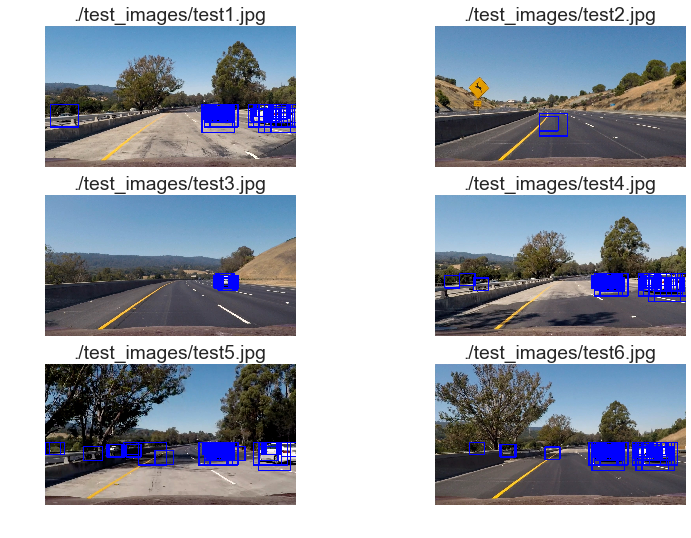

In [12]:

test_files = glob.glob('./test_images/*.jpg')
plt.figure()
for index, test_file in enumerate(test_files):
    image = mpimg.imread(test_file)
    image = image.astype(np.float32) / 255.
    draw_image = np.copy(image)
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 1), thick=6) 
    plt.subplot(3, 2, index + 1)
    plt.imshow(window_img)
    plt.axis('off')
    plt.title(test_file)
plt.savefig('./output_images/test_search.png')
    

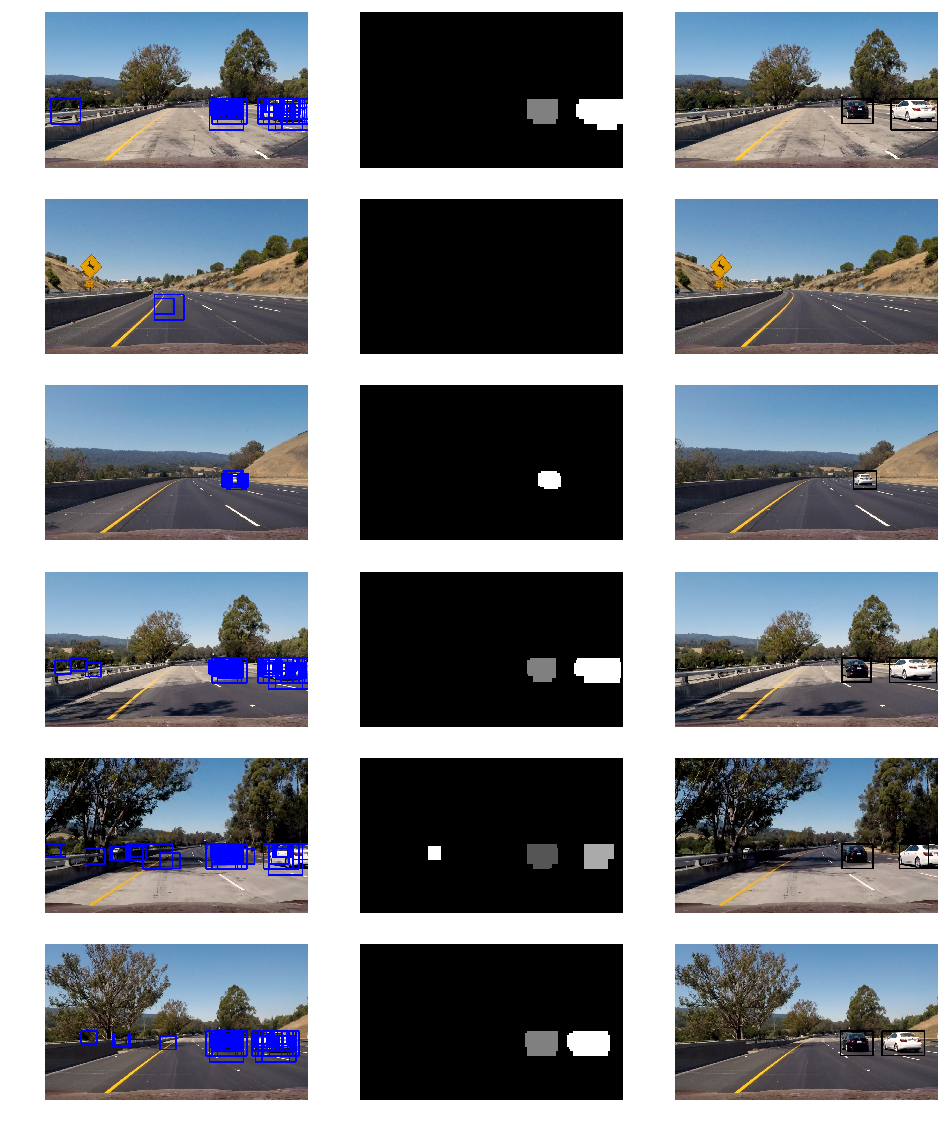

In [14]:
#Visualising how bounding boxes are made with heat map
t=time.time()

plt.style.use('ggplot')
plt.figure(figsize=(16,20))
# fig = plt.figure()
for index, test_file in enumerate(test_files):
    image = mpimg.imread(test_file)
    image = image.astype(np.float32) / 255.
    draw_image = np.copy(image)

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 1), thick=6) 

    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heatmap = add_heat(heat, hot_windows)
    heatmap = apply_threshold(heatmap, 2)
    labels = label(heatmap)

    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    plt.subplot(6, 3, 1 + index * 3)
    plt.imshow(window_img, aspect='auto')
    plt.axis('off')
    plt.subplot(6, 3, 2 + index * 3)
    plt.imshow(labels[0], cmap='gray', aspect='auto')
    plt.axis('off')
    plt.subplot(6, 3, 3 + index * 3)
    plt.imshow(draw_img[0], aspect='auto')
    plt.axis('off')
plt.savefig('./output_images/apply_heatmap.png')

In [14]:
#Creating video 
test1_output = 'project_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
test1_clip = clip1.fl_image(process_image)
%time test1_clip.write_videofile(test1_output, audio=False)


[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4



100%|█████████▉| 1260/1261 [8:21:21<00:05,  5.72s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

CPU times: user 3h 37min 27s, sys: 1min 23s, total: 3h 38min 51s
Wall time: 8h 21min 22s
